In [1]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn import metrics
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


/opt/homebrew/Caskroom/miniconda/base/envs/ravelin36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/homebrew/Caskroom/miniconda/base/envs/ravelin36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/homebrew/Caskroom/miniconda/base/envs/ravelin36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int1

In [2]:
gameweek_df = pd.read_csv('data/processed/combined_gameweeks.csv',parse_dates=['date'])

Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.


In [3]:
understat_df = pd.read_csv('data/processed/understat_raw.csv',parse_dates=['date'])

In [4]:
elo_df = pd.read_csv('data/processed/team_elos.csv')

In [5]:
understat_df['xC'] = understat_df.xG + understat_df.xA

In [6]:
gameweek_df['has_understat'] = gameweek_df['clean_name'].isin(understat_df.clean_name)

In [7]:
gameweek_df.groupby('season')['has_understat'].mean()

season
2018-19    0.463699
2019-20    0.569522
2020-21    0.695916
2021-22    0.729935
Name: has_understat, dtype: float64

In [8]:
gameweek_df['weighted_us'] = gameweek_df.minutes * gameweek_df.has_understat

In [9]:
gameweek_df.groupby('season')['weighted_us'].sum() /  gameweek_df.groupby('season')['minutes'].sum()

season
2018-19    0.618992
2019-20    0.737958
2020-21    0.886499
2021-22    0.892131
dtype: float64

I'm sure I can go further but this is a good start :)

In [10]:
UNDERSTAT_COLS = ['xG',
 'xA', 
 'npg', 'npxG', 'xGChain', 'xGBuildup','xC'
]

In [11]:
with_understat = gameweek_df.merge(understat_df[ UNDERSTAT_COLS + ['clean_name','date']],
                  how='left',
                  on=['clean_name','date'],suffixes=('','_u'))
with_xg_data = with_understat.loc[with_understat.xG.notna()]
num = with_xg_data.loc[with_xg_data.xG.notna()].groupby('season')['clean_name'].count() 

denom = gameweek_df.loc[gameweek_df.minutes > 0].groupby('season')['clean_name'].count()
num /denom

season
2018-19    0.599046
2019-20    0.720471
2020-21    0.882710
2021-22    0.884662
Name: clean_name, dtype: float64

I'll work with this for now :) 

In [12]:
assert len(gameweek_df) == len(with_understat)

In [13]:
with_understat[UNDERSTAT_COLS] = with_understat[UNDERSTAT_COLS].fillna(0)

In [14]:
with_elo = with_understat.merge(elo_df, how='left', on= ['team','season','gw'])

In [15]:
assert len(gameweek_df) == len(with_elo)

In [16]:
combined_df = with_elo

In [17]:
## can we help the model by showing the relationship between gk/defence and conceded?

In [18]:
combined_df['defensive_cleansheet'] = combined_df.clean_sheets & combined_df.position.isin(['DEF','MID'])

In [19]:
combined_df['defensive_goals_conceded'] = combined_df['goals_conceded'] 

In [20]:
combined_df.loc[~combined_df.position.isin(['DEF','MID']),['defensive_cleansheet',
                                                          'defensive_goals_conceded']] = np.nan

In [21]:
def add_moving_average(df, ma_columns, name_col,pref='ma4_', half_life=4):
    df = df.sort_values(by=[name_col, "season", "gw"]).reset_index(drop=True)
    ma_columns_output = [pref + c for c in ma_columns]
    df[ma_columns_output] = df.groupby(name_col)[ma_columns].apply(
        lambda x: x.ewm(halflife=half_life).mean()
    ).reset_index(drop=True)
    df[ma_columns_output] = df.groupby(name_col)[ma_columns_output].shift(1)
    return df

In [51]:
MA_COLS = [
    'assists', 'attempted_passes', 'big_chances_created',
       'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
       'clearances_blocks_interceptions', 'completed_passes', 'creativity',
       'dribbles', 'ea_index', 'errors_leading_to_goal',
       'errors_leading_to_goal_attempt', 'fouls', 'goals_conceded',
       'goals_scored', 'influence', 'key_passes',
        'loaned_in', 'loaned_out',
       'minutes', 'offside', 'open_play_crosses', 'opponent_team', 'own_goals',
       'penalties_conceded', 'penalties_missed', 'penalties_saved',
       'recoveries', 'red_cards', 'saves', 'selected', 'tackled',
       'tackles', 'target_missed', 'team_a_score', 'team_h_score', 'threat',
        'winning_goals', 'yellow_cards','total_points',
    'ict_index','xP','defensive_cleansheet','defensive_goals_conceded'
            ] + UNDERSTAT_COLS 

In [52]:
EXCLUDE_COLS = ['name','clean_name','element','id',
               'id', 'kickoff_time',
       'kickoff_time_formatted', 'round','fixture', 'date','weighted_us', 'has_understat', 'weight'] + MA_COLS 

In [53]:
combined_df['prev_selected'] = combined_df.groupby('clean_name')['selected'].shift(1)

In [54]:
combined_df.total_points =pd.to_numeric(combined_df.total_points)

In [55]:
cat_cols = combined_df.select_dtypes('O').columns
combined_df[cat_cols] = combined_df[cat_cols].astype('category')

In [56]:
HL = 20
with_ma = add_moving_average(combined_df, MA_COLS,'clean_name',pref=f'ma_{HL}_', half_life=HL)

In [57]:
with_ma['weight']= (pd.Timestamp.now() - with_ma.date).dt.days * with_ma.selected # higher weight on more recent data, and more highly selected players

In [58]:
train = with_ma[(with_ma.season != '2020-21') | (with_ma.gw <= 19)]
val = with_ma[(with_ma.season == '2020-21') & (with_ma.gw > 19)]
test = with_ma[with_ma.season == '2021-22']

In [59]:
X_train, X_test, X_val = train.drop(columns = EXCLUDE_COLS), test.drop(columns=EXCLUDE_COLS), val.drop(columns=EXCLUDE_COLS)
y_train, y_test, y_val = train.total_points, test.total_points, val.total_points
w_train, w_test, w_val = train.weight, test.weight, val.weight

In [60]:
def fit_with_early_stopping(X_train, y_train, X_val, y_val, w_train, w_val):
    reg = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=10_000)
    reg.fit(X_train,y_train,sample_weight=w_train,
                              eval_set=[(X_train, y_train), (X_val, y_val)], 
            early_stopping_rounds=10,verbose=100)
    num_trees = reg._Booster.num_trees()
    reg_2 = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=num_trees)
    reg_2.fit(X_train.append(X_val), y_train.append(y_val), sample_weight=w_train.append(w_val))
    return reg_2, num_trees

In [61]:
reg, num_trees = fit_with_early_stopping(X_train, y_train, X_val, y_val, w_train, w_val)

/opt/homebrew/Caskroom/miniconda/base/envs/ravelin36/lib/python3.6/site-packages/lightgbm/basic.py:1433: UserWarning:

Overriding the parameters from Reference Dataset.

/opt/homebrew/Caskroom/miniconda/base/envs/ravelin36/lib/python3.6/site-packages/lightgbm/basic.py:1245: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 10 rounds
[100]	training's l2: 10.3009	valid_1's l2: 5.35506
[200]	training's l2: 8.93749	valid_1's l2: 4.50913
[300]	training's l2: 8.08594	valid_1's l2: 4.3478
Early stopping, best iteration is:
[354]	training's l2: 7.7391	valid_1's l2: 4.31622


In [62]:
y_pred = reg.predict(X_test)

In [63]:
y_dummy = np.repeat(y_train.mean(), len(X_test))

In [64]:
metrics.mean_squared_error(y_pred,y_test,sample_weight=w_test)

10.992445685735541

In [65]:
metrics.mean_squared_error(y_dummy,y_test,sample_weight=w_test)

19.642834284497706

In [66]:
def create_shaps(X,y,reg):
    explainer = shap.TreeExplainer(reg)
    shap_values = explainer.shap_values(X)
    # rank features by importance - average abs. shap value
    importance_shap = np.abs(shap_values).mean(axis=0)
    ranked_features = sorted(
        list(zip(X.columns, importance_shap)), key=lambda x: -x[1]
    )  # sorted by importance (descending)
    features_df = pd.DataFrame(ranked_features, columns=["feature", "importance"])
    features_df["% total importance"] = (
        features_df.importance / features_df.importance.sum()
    ) * 100
    ax = sns.barplot(data=features_df.head(20), y="feature", x="% total importance")
    plt.title("Top 20 features \n % Average abs. Shap value importance (% total)")
    plt.show()
    ax = shap.summary_plot(
        shap_values,
        X,
    )
    plt.show()
    X_plot = X.copy()
    for col in X.select_dtypes("category").columns:
        X_plot[col] = X[col].cat.codes
    for feat in ranked_features[:10]:
        ax = shap.dependence_plot(
        ind=feat[0],
        shap_values=shap_values,
        features=X_plot,
        display_features=X,
        )
        plt.show()

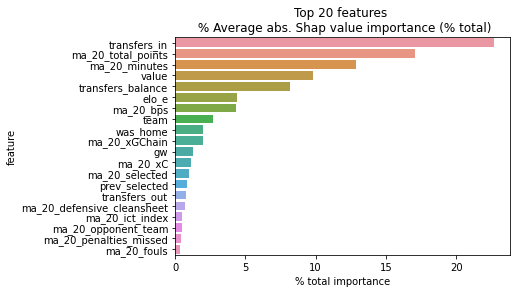

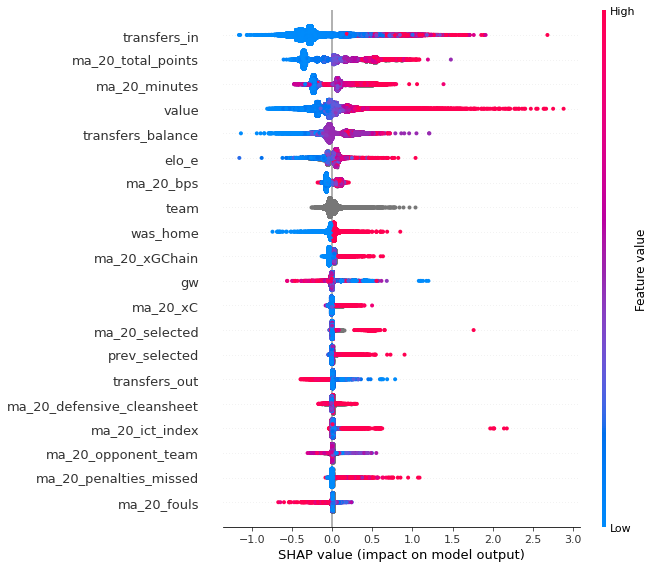

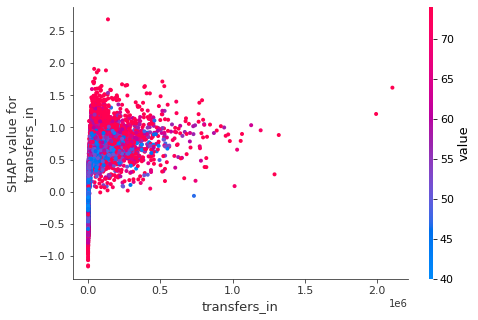

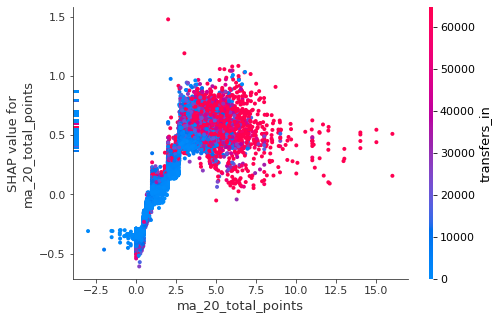

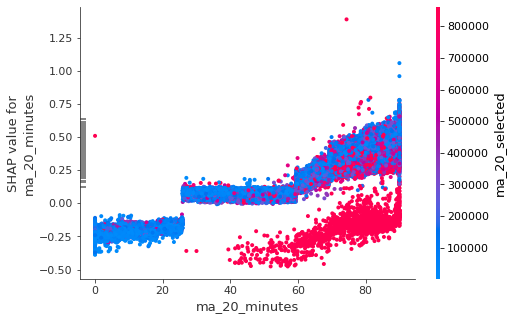

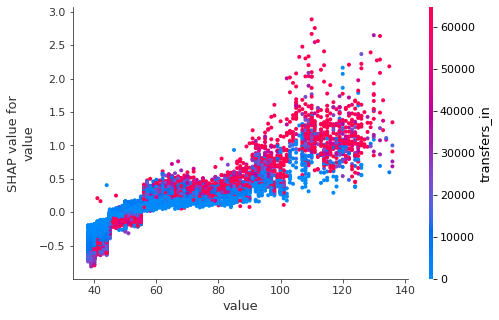

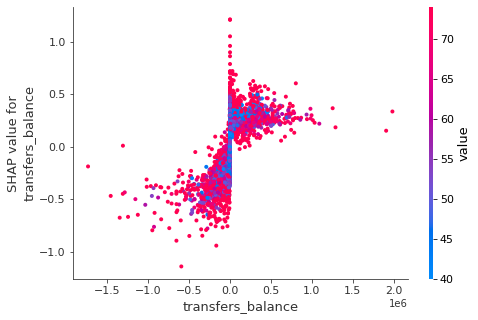

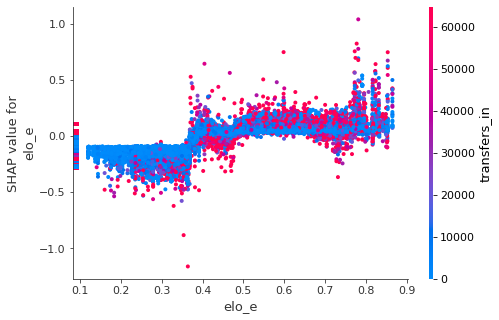

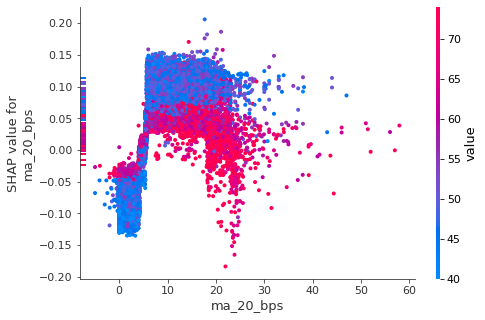

/opt/homebrew/Caskroom/miniconda/base/envs/ravelin36/lib/python3.6/site-packages/shap/plots/_scatter.py:718: MatplotlibDeprecationWarning:

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.



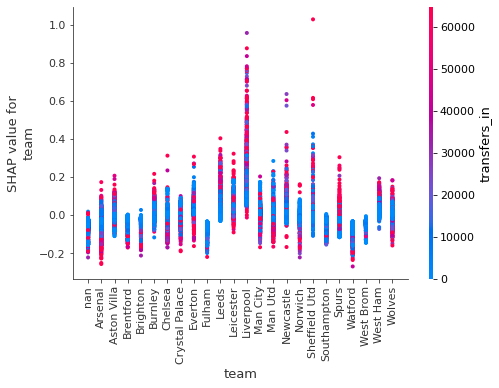

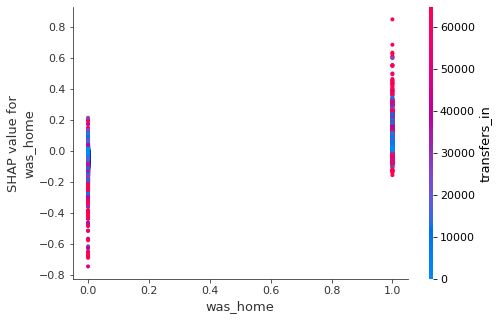

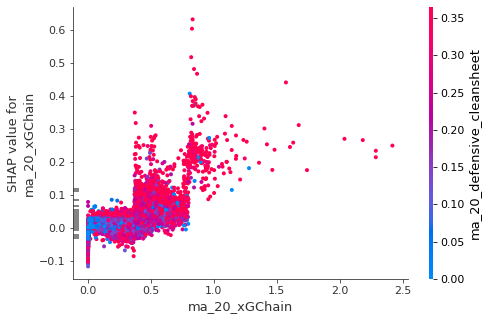

In [67]:
create_shaps(X_train,y_train,reg)

In [68]:
X = with_ma.drop(columns=EXCLUDE_COLS)

In [69]:
y = with_ma.total_points

In [70]:
w = with_ma.weight

In [71]:
reg_2 = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=num_trees)

In [72]:
reg_2.fit(X,y,w)

LGBMRegressor(learning_rate=0.01, n_estimators=354)

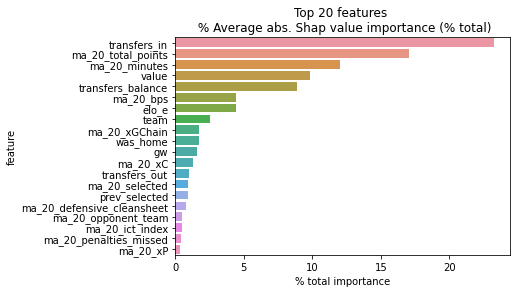

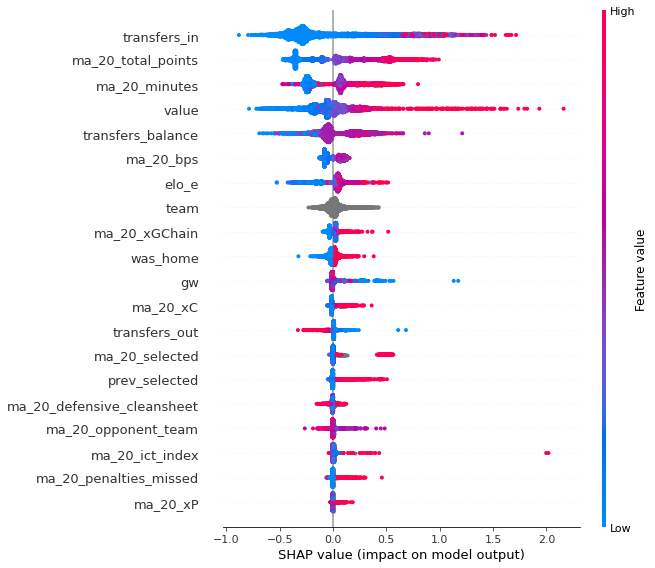

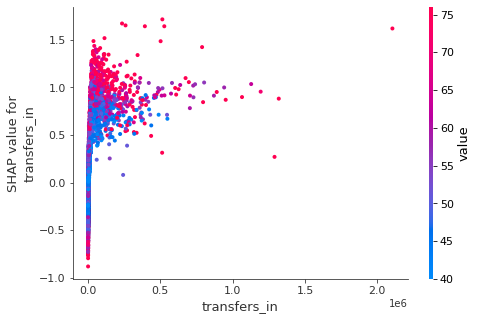

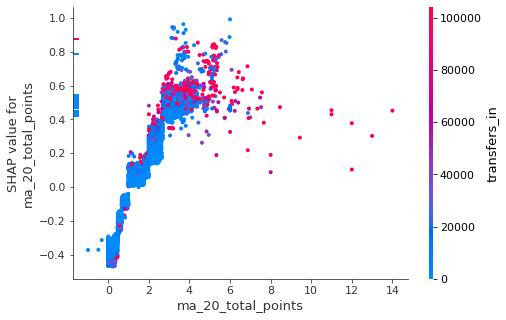

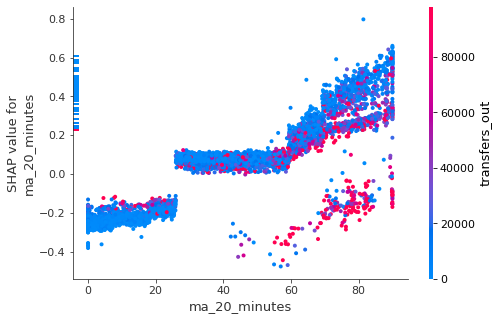

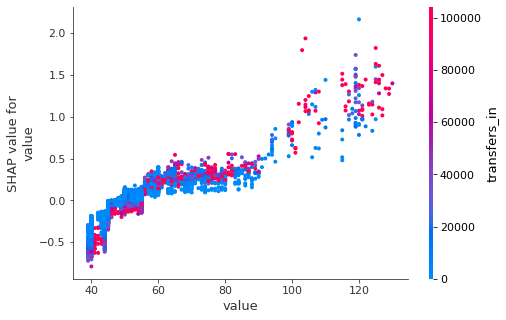

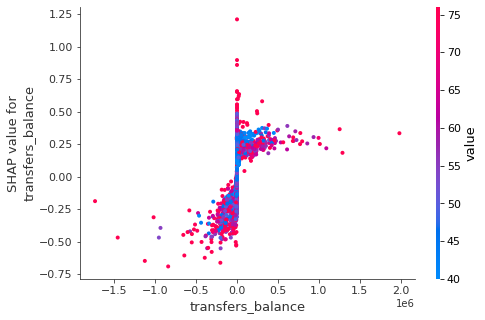

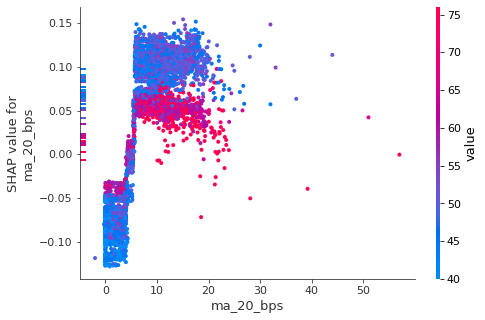

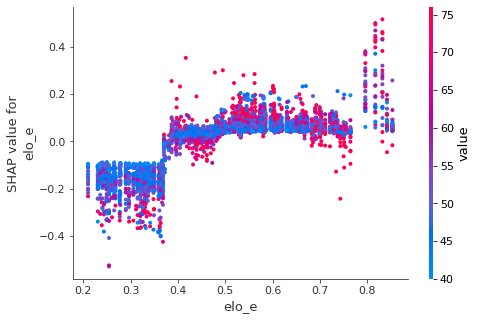

/opt/homebrew/Caskroom/miniconda/base/envs/ravelin36/lib/python3.6/site-packages/shap/plots/_scatter.py:718: MatplotlibDeprecationWarning:

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.



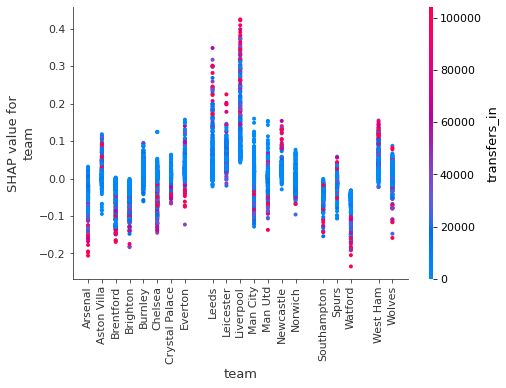

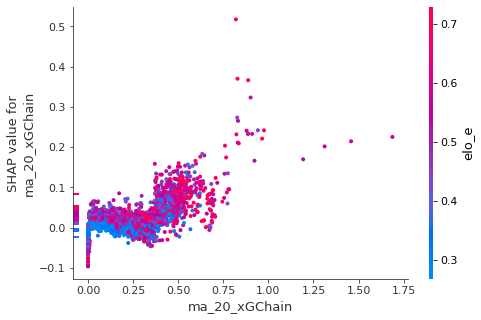

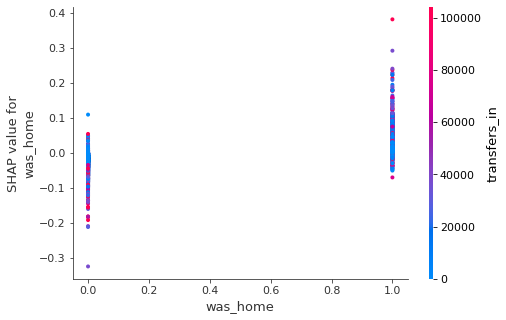

In [73]:
create_shaps(X_test,y_test,reg_2)

In [74]:
#a little leaky. What would the model predict for last week? 
_X_test = X_test.copy()
_X_test['pred'] = reg_2.predict(X_test)
_X_test['name'] = test.clean_name
_X_test['position'] =test.position
_X_test['elo_e'] = 0.5 # imagine playing a random team for now

In [75]:
latest = _X_test.drop_duplicates(subset=['name'],keep='last').copy()
latest['rank'] = latest.pred.rank(ascending=False)

In [76]:
top_40 = latest[['name','rank','pred','position','value',]].sort_values(by='pred',ascending=False).head(40); top_40

,name,rank,pred,position,value
62692,Son_Heung-Min,1.0,7.580880,MID,104
49075,Mohamed_Salah,2.0,6.362914,MID,130
25699,Harry_Kane,3.0,6.280094,FWD,122
30738,Jamie_Vardy,4.0,6.118438,FWD,107
59724,Sadio_Mané,5.0,5.602051,MID,119
55059,Pierre-Emerick_Aubameyang,6.0,5.116900,FWD,100
14312,Cristiano_Ronaldo,7.0,4.869048,FWD,124
55754,Raphinha,8.0,4.825932,MID,66
48341,Michail_Antonio,9.0,4.666529,FWD,82
66025,Trent_Alexander-Arnold,10.0,4.633779,DEF,77


In [48]:
fig = px.scatter(top_40, x="pred", y="value", text="name", log_x=True, color="position")
fig.update_traces(textposition='top center')
fig.update_layout(title_text='Points vs. Price', title_x=0.5)
fig.write_html('forecast points vs. price.html', auto_open=True)